In [36]:
import pandas as pd
import numpy as np

In [37]:
# Import and asses dataset
# Dataset description can be found at: https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset?select=covid.csv
df = pd.read_csv("../data/mexico_government_covid19_patient/covid.csv")
print(df.shape)
df.head()

(566602, 23)


,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [38]:
# Change the data died column to indicate if patient death
# If there is a valid date then patient death and represent as 1 otherwise represent as 2
df['date_died'] = df['date_died'].replace(to_replace="9999-99-99", value=2)
df['date_died'] = df['date_died'].mask(df['date_died'].ne(2), 1)
df = df.rename(columns={'date_died':'lethal'})
df.head()

,id,sex,patient_type,entry_date,date_symptoms,lethal,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,2,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,2,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,2,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,2,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,1,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [39]:
# With date_symptoms and entry_date we can calculate time between disease contraction and medical attention
# This would be a more relevant feature to use rather than just the dates
df['days_to_medical_help'] = (pd.to_datetime(df['entry_date'], dayfirst=True) - pd.to_datetime(df['date_symptoms'], dayfirst=True)).dt.days
df = df.drop(columns=['entry_date', 'date_symptoms'])
df.head()

,id,sex,patient_type,lethal,intubed,pneumonia,age,pregnancy,diabetes,copd,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,days_to_medical_help
0,16169f,2,1,2,97,2,27,97,2,2,...,2,2,2,2,2,2,2,1,97,2
1,1009bf,2,1,2,97,2,24,97,2,2,...,2,2,2,2,2,2,99,1,97,2
2,167386,1,2,2,2,2,54,2,2,2,...,2,2,2,1,2,2,99,1,2,5
3,0b5948,2,2,2,2,1,30,97,2,2,...,2,2,2,2,2,2,99,1,2,7
4,0d01b5,1,2,1,2,2,60,2,1,2,...,1,2,1,2,2,2,99,1,2,0


In [40]:
# Drop Patient ID from the dataset since it won't help in predictions
columns_to_drop = ['id']
df = df.drop(columns=columns_to_drop)

In [41]:
# Since most categorical features are currently int64 change them to categorical
# We also want to normalize all non categorical features
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
categorical_columns = ['sex', 'patient_type',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu', 'lethal']
# The dataset indicates that missing values are 97, 98, 99 so we replace them with -1 for uniformity
scalers = {}
for column in df.columns:
    if column in categorical_columns:
        # Change no encoding from 2 to 0
        df[column] = df[column].replace(to_replace=2, value=0)
        # Replace all missing values with -1
        df[column] = df[column].replace(to_replace=[97, 98, 99], value=-1).astype('category')
    else:
        # Normalize non categorical features
        scalers[column] = MinMaxScaler().fit(np.array(df[column]).reshape(-1, 1))
        df[column] = scalers[column].transform(np.array(df[column]).reshape(-1, 1))[:, 0]
        dump(scalers[column], str(column) + '_scaler.joblib') 

In [42]:
# Now we can only use observations in which the individual tested postive for COVID 19
covid_cases = df[df['covid_res'] == 1]
covid_cases.shape

(220657, 21)

In [43]:
# Encoding of 3 for 'covid_res' is supposed to be awaiting results so we can use these as the prediction set for risk assesment
awaiting_cases = df[df['covid_res'] == 3]
awaiting_cases.shape

(66910, 21)

In [44]:
# Variables to store the outcomes and features
# We could try combining icu and death
# However we do not want to include either in the prediction for the other due to expected high dependency
features = ['sex', 'patient_type', 'age', 'days_to_medical_help',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']
"""features = ['sex', 'age', 'days_to_medical_help', 'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']"""
outcomes = ['icu', 'death']

In [45]:
# First we train a model to predict 'icu' for that we form a dataset of known icu cases i.e Yes or No so we remove 0s which were
# supposed to be missing values or cases in which we do not know if the individual was in the icu
current_outcome = outcomes[0] # i.e 'icu'
icu_res_known = covid_cases[covid_cases['icu'] != -1]
icu_res_known.shape

(68210, 21)

In [46]:
# Split data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(icu_res_known, shuffle=True, test_size=0.3, stratify=icu_res_known['icu'])

In [47]:
# The above graph indicates that the data is highly biased so we must perform some sampling to balance the dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Over Sample the Minority Label to be 0.3 in proportion
over = SMOTE(sampling_strategy=0.3)
# Down Sample the Majority Label so that there are twice as many as minority
under = RandomUnderSampler(sampling_strategy=0.5)
# Pipeline to combine 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# Sampled data
obs, results = pipeline.fit_resample(train[features], train['icu'])
obs = obs.fillna(0)

In [54]:
# Now that we have trained on Random Forest Let us test the baselines for all classifiers within the sklearn library
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
classifiers = [
    #KNeighborsClassifier(2),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=20),
    MLPClassifier(max_iter=10000),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
]

"""names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]"""
names = ["Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

def ensembleLearner(names, classifiers, obs, results, test_obs, test_results):
    predictions = []
    for name, clf in zip(names, classifiers):
        print("Training {}".format(name))
        clf.fit(obs, results)
        pred_clf = clf.predict_proba(obs)
        predictions.append(pred_clf[:, 0])
    predictions = np.transpose(np.array(predictions))
    print(predictions.shape)
    ensemble_clf = LogisticRegression(max_iter=100, C=0.6).fit(predictions, results)
    
    test_predictions = []
    for name, clf in zip(names, classifiers):
        print("Forming Test {}".format(name))
        test_predictions.append(clf.predict_proba(test_obs)[:, 0])
    test_predictions = np.transpose(np.array(test_predictions))
    print(test_predictions.shape)
    
    train_score =  ensemble_clf.score(predictions, results)
    metrics_train = precision_recall_fscore_support(results, ensemble_clf.predict(predictions))
    test_score = ensemble_clf.score(test_predictions, test_results)
    metrics_test = precision_recall_fscore_support(test_results, ensemble_clf.predict(test_predictions))
    print("Train Accuracy: {}".format(train_score))
    print("Train Precision: {}\nTrain Recall: {}\nTrain F-Score: {}\n".format(metrics_train[0], metrics_train[1], metrics_train[2]))
    print("Test Accuracy: {}".format(test_score))
    print("Test Precision: {}\nTest Recall: {}\nTest F-Score: {}".format(metrics_test[0], metrics_test[1], metrics_test[2]))
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(ensemble_clf, predictions, results,
                                     display_labels=['no', 'yes'],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()


Training Decision Tree
Training Random Forest
Training Neural Net
Training AdaBoost
Training Naive Bayes
(39303, 5)
Forming Test Decision Tree
Forming Test Random Forest
Forming Test Neural Net
Forming Test AdaBoost
Forming Test Naive Bayes
(20463, 5)
Train Accuracy: 0.9691372159886014
Train Precision: [0.97383291 0.95956394]
Train Recall: [0.98003969 0.94733226]
Train F-Score: [0.97692644 0.95340887]

Test Accuracy: 0.857743243903631
Test Precision: [0.94204844 0.274942  ]
Test Recall: [0.89981834 0.4069834 ]
Test F-Score: [0.92044927 0.32817909]
Confusion matrix, without normalization
[[25679   523]
 [  690 12411]]
Normalized confusion matrix
[[0.98003969 0.01996031]
 [0.05266774 0.94733226]]


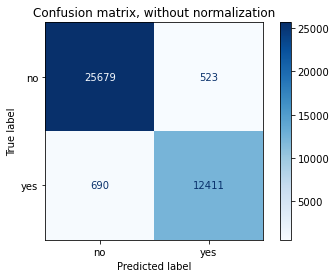

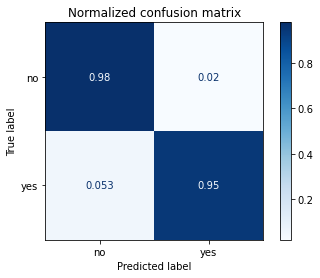

In [55]:
ensembleLearner(names, classifiers, obs, results, test[features], test['icu'])